
# compare model resolution to Rossby radius
# data downloaded from https://ceoas.oregonstate.edu/rossby_radius
# Reference: https://journals.ametsoc.org/view/journals/phoc/28/3/1520-0485_1998_028_0433_gvotfb_2.0.co_2.xml
# possible addition to Fig. 2 in GMD paper after first round of reviews


In [1]:

import sys
sys.path.append('/global/homes/c/cnissen/scripts/seawater-3.3.4/seawater/')
import os
import numpy as np
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import cm
import seawater
#from seawater import dist
#import seawater as sw
import matplotlib.path as mpath
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
import random
from numba import njit
from math import sin, cos, sqrt, atan2, radians


In [2]:
#-----
# saving plots
#-----

savepath     = '/global/cfs/cdirs/m4003/cnissen/Plots/E3SM_floats/map_initial_positions/'
# check existence of paths
if not os.path.exists(savepath):
    print ('Created '+savepath)
    os.makedirs(savepath)
    

In [3]:
####
# specifics for trajectory output
####

rad_to_deg = 180.0/np.pi
latlim = -45.0

path_mesh = '/global/cfs/cdirs/m4003/maltrud/'
meshID = 'EC30to60E2r2'
meshfile = xr. open_dataset(path_mesh+'ocean.'+meshID+'.210210.nc')
#print(meshfile)

lon  = meshfile['lonCell'].values*rad_to_deg
lat  = meshfile['latCell'].values*rad_to_deg
topo = meshfile['bottomDepth'].values
area = meshfile['areaCell'].values
zlevs            = meshfile['refBottomDepth'].values
layerThickness   = meshfile['layerThickness'].values
restingThickness = meshfile['restingThickness'].values

print(len(lon),'nodes in mesh')
print(topo.shape)
print(area.shape)
print('Min/Max lon:',np.min(lon),np.max(lon))
print('Min/Max lat:',np.min(lat),np.max(lat))
print('layerThickness.shape:',layerThickness.shape)
print('restingThickness.shape:',restingThickness.shape)

meshfile.close()



236853 nodes in mesh
(236853,)
(236853,)
Min/Max lon: 0.0007300572350528742 359.997672445938
Min/Max lat: -78.53259417674468 89.94461290099375
layerThickness.shape: (1, 236853, 60)
restingThickness.shape: (236853, 60)


(236853,) 30106.32853577548 74612.89300200665
12 180
No grid cells for latitutde 0 -90
No grid cells for latitutde 1 -89
No grid cells for latitutde 2 -88
No grid cells for latitutde 3 -87
No grid cells for latitutde 4 -86
No grid cells for latitutde 5 -85
No grid cells for latitutde 6 -84
No grid cells for latitutde 7 -83
No grid cells for latitutde 8 -82
No grid cells for latitutde 9 -81
No grid cells for latitutde 10 -80
No grid cells for latitutde 180 90
34.58103753210279 68.97279726060968


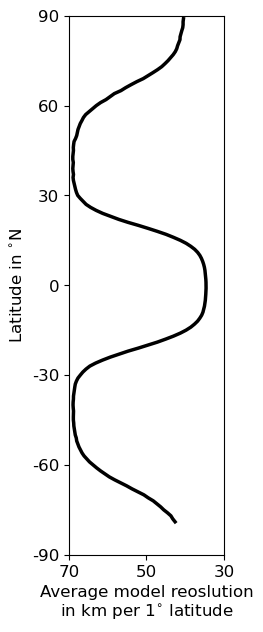

In [4]:
#---
# get resolution of mesh
#---
#print(area.shape)
#print(lat.shape,lon.shape)

# use the following relationship: Area of hexagon = (3*sqrt(3)*a2)/2, with a being the length of a side or the radius
# solve for "a" and multiply by 2 to get the resolution
res = np.sqrt((2/3)*area/np.sqrt(3))*2
print(res.shape,np.min(res),np.max(res))

#---
# Model resolution: get avg for each latitude
#---

#print(len(lat_float))

lat_bins = np.arange(-90,90+1,1)

ind_bin = np.digitize(lat,lat_bins)
print(np.min(ind_bin),np.max(ind_bin))

avg_res_per_lat_bin = np.nan*np.ones(len(lat_bins))
for ii in range(0,len(lat_bins)):
    ind = np.where(ind_bin==ii+1)[0] # check if there should be a "+1" here or not
    if len(ind)>0:
        avg_res_per_lat_bin[ii] = np.sum(area[ind]*res[ind])/np.sum(area[ind])  #ind.shape[0]
    else:
        print('No grid cells for latitutde',ii,lat_bins[ii])
    del ind

print(np.nanmin(avg_res_per_lat_bin/1000),np.nanmax(avg_res_per_lat_bin/1000))

    
save_plots = False
plot_eps = False

#---
# plot: avg resoluton per latitude 
#---
lw = 2.5
fs = 12

color1 = 'black'

fig = plt.figure(figsize=(2,7))
plt.plot(avg_res_per_lat_bin/1000,lat_bins,color=color1,linewidth=lw)
plt.ylabel('Latitude in $^{\circ}$N',fontsize=fs)
plt.xlabel('Average model reoslution\nin km per 1$^{\circ}$ latitude',fontsize=fs)
plt.ylim((-90,90))
plt.xlim((30,70))
plt.xticks([30,50,70],[30,50,70],fontsize=fs)
plt.yticks([-90,-60,-30,0,30,60,90],[-90,-60,-30,0,30,60,90],fontsize=fs)
plt.gca().invert_xaxis()

if save_plots:
    dpicnt = 200
    filename = 'Model_resolution_avg_per_latitude.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='png')#,transparent=True)
    
    
plt.show()



#---
# EPS
# plot: avg resoluton per latitude 
#---
lw = 2.5
fs = 12

color1 = 'black'

if plot_eps:
    fig = plt.figure(figsize=(2,7))
    plt.plot(avg_res_per_lat_bin/1000,lat_bins,color=color1,linewidth=lw)
    #plt.ylabel('Latitude in $^{\circ}$N',fontsize=fs)
    #plt.xlabel('Average model reoslution\nin km per 1$^{\circ}$ latitude',fontsize=fs)
    plt.ylim((-90,90))
    plt.xlim((30,70))
    plt.xticks([30,50,70],[],fontsize=fs)
    plt.yticks([-90,-60,-30,0,30,60,90],[],fontsize=fs)
    plt.gca().invert_xaxis()

    if save_plots:
        dpicnt = 200
        filename = 'Model_resolution_avg_per_latitude.eps'
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='eps')#,transparent=True)
    plt.show()


    




In [5]:
#---
# load data for Rossby radius of deformation
#---
# columns in file: 
#  latitude in degrees from -75.5 to 89.5 (negative for southern hemisphere)
#  longitude in degrees east from 0.5 to 359.5
#  baroclinic gravity-wave phase speed c in m/s
#  baroclinic Rossby radius of deformation r in km.


path1 = '/pscratch/sd/c/cnissen/rossby_radius/'
file1 = 'rossrad.dat'

# read all columns first
f=open(path1+file1,"r")
lines=f.readlines()
all_columns=[]
for x in lines:
    all_columns.append(x)
f.close()

# split into different columns
lat_rossby=[]
lon_rossby=[]
radius_rossby=[]
for nn in range(0,len(all_columns)):
    aux = all_columns[nn].split()
    lat_rossby.append(float(aux[0]))
    lon_rossby.append(float(aux[1]))
    radius_rossby.append(float(aux[3]))
    del aux   

print('min/max lat:',np.min(lat_rossby),np.max(lat_rossby))
print('min/max lon:',np.min(lon_rossby),np.max(lon_rossby))
print('min/max Rossby radius:',np.min(radius_rossby),np.max(radius_rossby))



min/max lat: -75.5 89.5
min/max lon: 0.5 359.5
min/max Rossby radius: 3.762 263.068


In [6]:
#---
# get avg Rossby radius for each latitude
#---

lat_bins = np.arange(-90,90+1,1)

ind_bin = np.digitize(lat_rossby,lat_bins)
print(np.min(ind_bin),np.max(ind_bin))

avg_rossby_per_lat_bin = np.nan*np.ones(len(lat_bins))
for ii in range(0,len(lat_bins)):
    ind = np.where(ind_bin==ii+1)[0] # check if there should be a "+1" here or not
    if len(ind)>0:
        avg_rossby_per_lat_bin[ii] = np.mean(np.asarray(radius_rossby)[ind]) #ind.shape[0]
    else:
        print('No grid cells for latitutde',ii,lat_bins[ii])
    del ind
    

15 180
No grid cells for latitutde 0 -90
No grid cells for latitutde 1 -89
No grid cells for latitutde 2 -88
No grid cells for latitutde 3 -87
No grid cells for latitutde 4 -86
No grid cells for latitutde 5 -85
No grid cells for latitutde 6 -84
No grid cells for latitutde 7 -83
No grid cells for latitutde 8 -82
No grid cells for latitutde 9 -81
No grid cells for latitutde 10 -80
No grid cells for latitutde 11 -79
No grid cells for latitutde 12 -78
No grid cells for latitutde 13 -77
No grid cells for latitutde 180 90


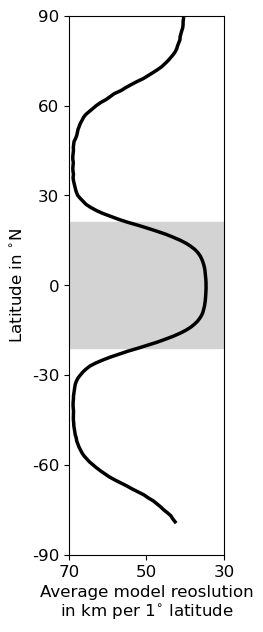

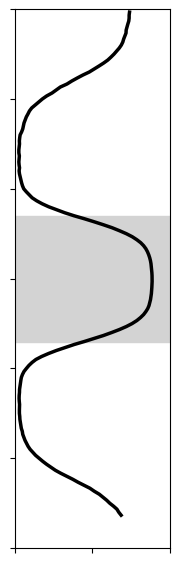

In [7]:
#----
# plot
#----

#---
# plot: avg resoluton per latitude with eddy-permitting region
#---
lw = 2.5
fs = 12

color1 = 'black'
color2 = 'cornflowerblue'

save_plots = True
plot_eps = True


fig = plt.figure(figsize=(2,7))
#plt.plot(avg_rossby_per_lat_bin,lat_bins,color=color1,linewidth=lw)
plt.plot(avg_res_per_lat_bin/1000,lat_bins,color=color1,linewidth=lw)

# color area that is eddy-permitting
aux1 = np.log(avg_rossby_per_lat_bin/(avg_res_per_lat_bin/1000))
ind_eddy_permitting = np.asarray(lat_bins)[np.where((aux1>0) & (aux1<10))[0]]
y1 = ind_eddy_permitting[0]
y2 = ind_eddy_permitting[-1]
plt.fill_between([3,75], y1, y2,color='lightgrey')

plt.ylabel('Latitude in $^{\circ}$N',fontsize=fs)
plt.xlabel('Average model reoslution\nin km per 1$^{\circ}$ latitude',fontsize=fs)
plt.ylim((-90,90))
plt.xlim((30,70))
plt.xticks([30,50,70],[30,50,70],fontsize=fs)
plt.yticks([-90,-60,-30,0,30,60,90],[-90,-60,-30,0,30,60,90],fontsize=fs)
plt.gca().invert_xaxis()

if save_plots:
    dpicnt = 200
    filename = 'Model_resolution_avg_per_latitude_with_eddy_permitting.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='png')#,transparent=True)
plt.show()

if plot_eps:
    fig = plt.figure(figsize=(2,7))
    plt.plot(avg_res_per_lat_bin/1000,lat_bins,color=color1,linewidth=lw)

    # color area that is eddy-permitting
    aux1 = np.log(avg_rossby_per_lat_bin/(avg_res_per_lat_bin/1000))
    ind_eddy_permitting = np.asarray(lat_bins)[np.where((aux1>0) & (aux1<10))[0]]
    y1 = ind_eddy_permitting[0]
    y2 = ind_eddy_permitting[-1]
    plt.fill_between([3,75], y1, y2,color='lightgrey')

    plt.ylim((-90,90))
    plt.xlim((30,70))
    plt.xticks([30,50,70],[],fontsize=fs)
    plt.yticks([-90,-60,-30,0,30,60,90],[],fontsize=fs)
    plt.gca().invert_xaxis()

    if save_plots:
        dpicnt = 200
        filename = 'Model_resolution_avg_per_latitude_with_eddy_permitting.eps'
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='eps')#,transparent=True)
plt.show()



In [9]:
print(y1,y2)

-21 21


In [8]:
print(savepath)

/global/cfs/cdirs/m4003/cnissen/Plots/E3SM_floats/map_initial_positions/
